# RFM Customer Grading Scale
Hello. We are going to get real customer transactions from a store and going to run our RFM Customer Grading Scale to quicky gauge the customers based on the how recent they visit, how many times they visisted and total spend.

## Imports and setup

In [1]:
import pandas as pd
import numpy as np
import random
import sys
import os

sys.path.append(os.path.abspath('..'))
from utils.db import get_db

In [2]:
engine = get_db()
start_date = '5/01/2025'
end_date = '6/17/2025'

## Query Database

only use f-strings for queries when you have full control (no user input because of injection). User parameterized instead.

In [3]:
query = f"""
select customer_id, sale_date, sum(total_sales) as sales
    from sales
    where store_number='440'
    and sale_type in ('Sale')
    and item_ring_type in ('ITEM', 'SUBD')
    and sale_date between '{start_date}' and '{end_date}'
group by customer_id, sale_date
order by sale_date

"""

## Datasets and RFM


In [4]:
ds = pd.read_sql(query, engine)

2025-06-19 15:24:48,180 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2025-06-19 15:24:48,182 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-06-19 15:24:48,241 INFO sqlalchemy.engine.Engine select current_schema()
2025-06-19 15:24:48,241 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-06-19 15:24:48,293 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2025-06-19 15:24:48,294 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-06-19 15:24:48,351 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-06-19 15:24:48,353 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname

### Lets check data numbers and drop any non customer transactions

In [5]:
ds.head(10)

row_count = ds.shape[0]

print(row_count)

15370


In [7]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15370 entries, 0 to 15369
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  15323 non-null  object        
 1   sale_date    15370 non-null  datetime64[ns]
 2   sales        15370 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 360.4+ KB


In [8]:

ds = ds[(ds['customer_id'].notna())]

row_count = ds.shape[0]
print(row_count)

15323


## RFM Dataset Begin


In [ ]:
today = pd.to_datetime('6/19/2025')#

In [10]:
rfm = ds.groupby('customer_id').agg(
    {
        'sale_date': lambda e: (today - e.max()).days,
        'customer_id': 'count',
        'sales': 'sum'
    }
)

In [11]:
rfm

,sale_date,customer_id,sales
customer_id,,,
40000000170.0,10,6,401.66
40000000711.0,17,1,4.87
40000001066.0,3,1,15.19
40000005005.0,3,27,1771.16
40000005011.0,9,6,146.44
...,...,...,...
440802.0,21,2,75.73
440804.0,2,9,308.02
440809.0,4,9,664.63


### rename columns for rfm processes

In [12]:
rfm.columns = ['recency', 'frequency', 'monetary']

In [13]:
rfm.describe()

,recency,frequency,monetary
count,2880.00000,2880.000000,2880.000000
mean,14.00625,5.320486,241.777934
std,12.60427,5.355484,284.344881
min,2.00000,1.000000,0.900000
25%,4.00000,1.000000,54.172500
50%,9.00000,4.000000,142.425000
75%,21.00000,7.000000,326.052500
max,49.00000,43.000000,3318.830000


In [14]:
rfm['r_score'] = pd.qcut(rfm['recency'], 4, labels=[4,3,2,1])
rfm['f_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['m_score'] = pd.qcut(rfm['monetary'],4, labels=[1,2,3,4])

rfm['rfm_segment'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str)
rfm['rfm_score'] = rfm[['r_score', 'f_score', 'm_score']].astype(int).sum(axis=1)
rfm['rfm_percent'] = (rfm['rfm_score'].astype(int)/12) *100

In [15]:
rfm.sort_values(['rfm_percent'], ascending= False)

,recency,frequency,monetary,r_score,f_score,m_score,rfm_segment,rfm_score,rfm_percent
customer_id,,,,,,,,,
440597.0,2,17,1247.87,4,4,4,444,12,100.0
40000005117.0,2,10,505.66,4,4,4,444,12,100.0
40000005108.0,2,17,479.35,4,4,4,444,12,100.0
40000005099.0,2,15,1338.59,4,4,4,444,12,100.0
40000005087.0,2,13,872.79,4,4,4,444,12,100.0
...,...,...,...,...,...,...,...,...,...
41451000531.0,25,1,49.74,1,1,1,111,3,25.0
41451006687.0,40,1,9.91,1,1,1,111,3,25.0
41461002268.0,22,1,10.03,1,1,1,111,3,25.0


### Now we are going to scale and grade the data based on the percentage score we got back

In [16]:
def segment_customer(row):
    if row['rfm_percent'] >= 85:
        return 'A'
    elif 84 >= row['rfm_percent'] >= 75:
        return 'B'
    elif 74 >= row['rfm_percent'] >= 65:
        return 'C'
    elif 64 >= row['rfm_percent']:
        return 'D'
    else:
        return 'NA'

### we want to reindex the segment for additonal reporting purposes

In [17]:
rfm['segment'] = rfm.apply(segment_customer, axis=1)
rfm['segment'].value_counts().reindex(['A','B','C','D'])

segment
A     639
B     563
C     256
D    1422
Name: count, dtype: int64

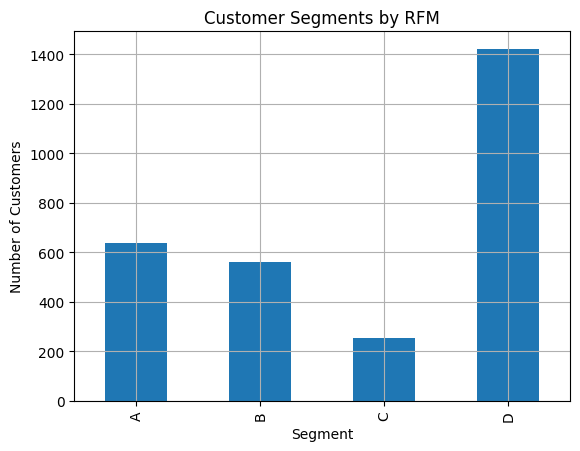

In [18]:
import matplotlib.pyplot as plt

rfm['segment'].value_counts().reindex(['A','B','C','D']).plot(kind='bar')
plt.title("Customer Segments by RFM")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.grid(True)
plt.show()

###get the data out of the orginal df, get it into another df, get the filtering and the wrap it in the orginal df or you will get a Boolean Seris back

In [19]:
##what about a scatter plot for the customer_ids in the A?
a_scale = rfm[rfm['segment']== 'A']
b_scale = rfm[rfm['segment']== 'B']
c_scale = rfm[rfm['segment']== 'C']
d_scale = rfm[rfm['segment']== 'D']

a_scale.head(10)

,recency,frequency,monetary,r_score,f_score,m_score,rfm_segment,rfm_score,rfm_percent,segment
customer_id,,,,,,,,,,
40000005005.0,3,27,1771.16,4,4,4,444,12,100.000000,A
40000005073.0,2,8,218.58,4,4,3,443,11,91.666667,A
40000005082.0,4,6,349.54,4,3,4,434,11,91.666667,A
40000005086.0,2,16,446.47,4,4,4,444,12,100.000000,A
40000005087.0,2,13,872.79,4,4,4,444,12,100.000000,A
40000005091.0,2,13,294.02,4,4,3,443,11,91.666667,A
40000005093.0,8,8,483.65,3,4,4,344,11,91.666667,A
40000005097.0,2,8,301.25,4,4,3,443,11,91.666667,A
40000005099.0,2,15,1338.59,4,4,4,444,12,100.000000,A


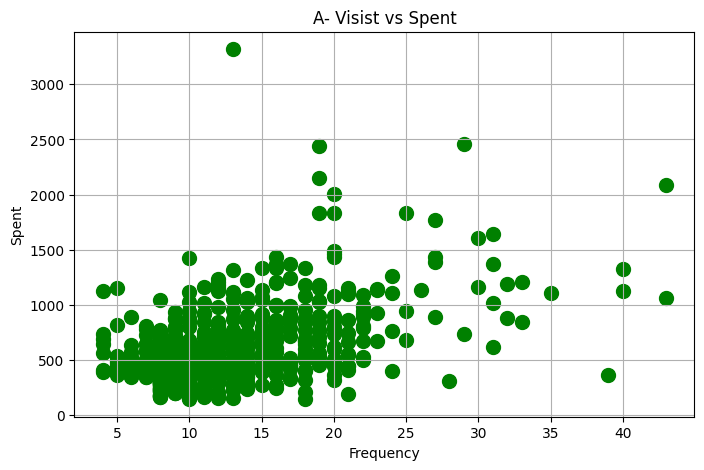

In [20]:
plt.figure(figsize=(8,5))
plt.scatter(a_scale['frequency'], a_scale['monetary'], color='green', s=100)

plt.xlabel('Frequency')
plt.ylabel('Spent')
plt.title('A- Visist vs Spent')
plt.grid(True)

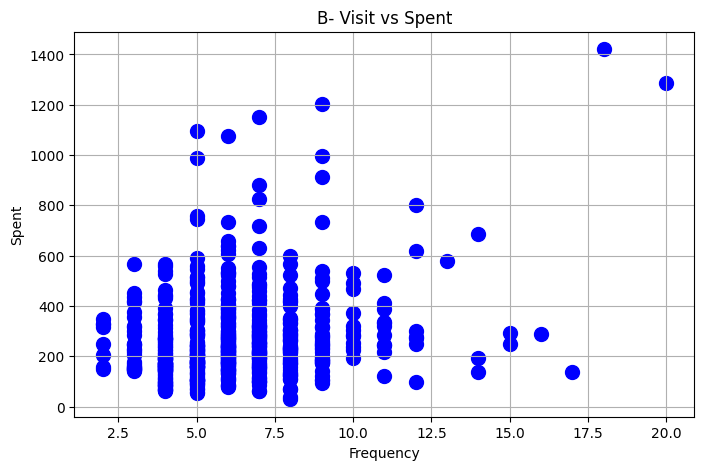

In [21]:
plt.figure(figsize=(8,5))
plt.scatter(b_scale['frequency'], b_scale['monetary'], color='blue', s=100)

plt.xlabel('Frequency')
plt.ylabel('Spent')
plt.title('B- Visit vs Spent')
plt.grid(True)

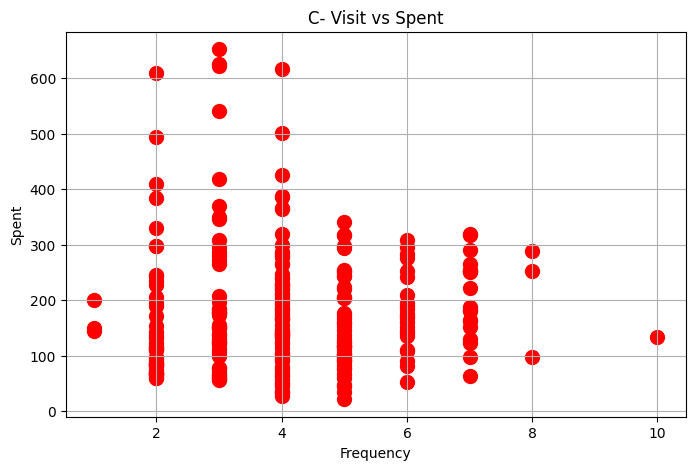

In [22]:
plt.figure(figsize=(8,5))
plt.scatter(c_scale['frequency'], c_scale['monetary'], color='red', s=100)

plt.xlabel('Frequency')
plt.ylabel('Spent')
plt.title('C- Visit vs Spent')
plt.grid(True)

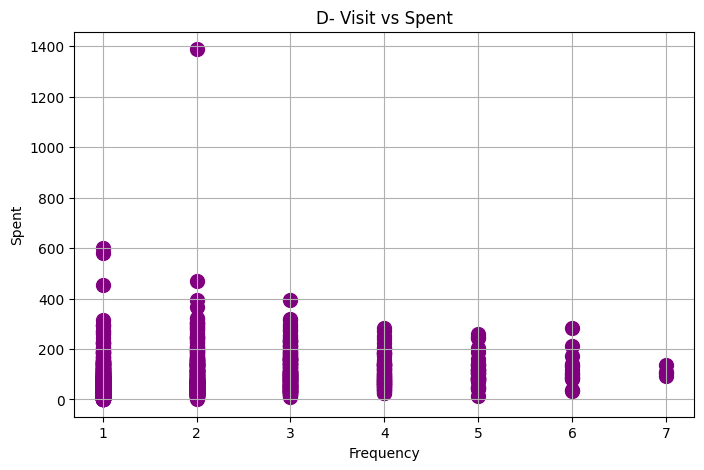

In [23]:
plt.figure(figsize=(8,5))
plt.scatter(d_scale['frequency'], d_scale['monetary'], color='purple', s=100)

plt.xlabel('Frequency')
plt.ylabel('Spent')
plt.title('D- Visit vs Spent')
plt.grid(True)

### Actually you would need this to be A cusomter for a time period to A customers again.  Lets try to make a Transtion Matrix to show movement from one segment to another  We are going to try to apply logic of A customer segment to B customer segemnt...

In [24]:
transition_df = a_scale

,recency,frequency,monetary,r_score,f_score,m_score,rfm_segment,rfm_score,rfm_percent,segment
customer_id,,,,,,,,,,
40000005005.0,3,27,1771.16,4,4,4,444,12,100.000000,A
40000005073.0,2,8,218.58,4,4,3,443,11,91.666667,A
40000005082.0,4,6,349.54,4,3,4,434,11,91.666667,A
40000005086.0,2,16,446.47,4,4,4,444,12,100.000000,A
40000005087.0,2,13,872.79,4,4,4,444,12,100.000000,A
...,...,...,...,...,...,...,...,...,...,...
440675.0,5,13,3318.83,3,4,4,344,11,91.666667,A
440687.0,2,16,765.33,4,4,4,444,12,100.000000,A
440694.0,3,19,2155.00,4,4,4,444,12,100.000000,A
